In [16]:
import time
import pickle
import torch
import pickle
import argparse
import matplotlib.pyplot as plt
import os
import dask.bag as db
import argparse
import glob
import io
from dask.distributed import Client, LocalCluster
import dask
import json
from networkx.readwrite import json_graph
import networkx as nx
import torch.nn.functional as F
import dgl
import stardog
import pandas as pd
import numpy as np
import pytz
from datetime import datetime
# import datetime as dt
def read_json_graph(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
Working_Directory = ""
os.chdir(Working_Directory)

In [2]:
connection_details = {
  'endpoint': 'http://localhost:5820',
  'username': '',
  'password': ''
}
database_name = 'tc3-cadets'
conn = stardog.Connection(database_name, **connection_details)
dataset = "darpa_cadets"
query_graphs = {}
for graph_name in glob.glob('./dataset/darpa_cadets/query_graphs/*'):
    query_graphs[graph_name.replace(".json","").split("/")[-1]] = read_json_graph(graph_name)
ioc_f = "./dataset/darpa_cadets/query_graphs_IOCs.json"
with open(ioc_f) as f:
    query_graphs_IOCs = json.load(f)

# Investigation Scripts

In [11]:
Query_Event_Timestamp = """
    PREFIX <GRAPH_NAME>: <http://grapt.org/darpa_tc3/cadets/<GRAPH_NAME>/> 
SELECT DISTINCT ?action ?timestamp
WHERE {
    <<?s ?action ?o>> <GRAPH_NAME>:timestamp ?timestamp .
    ?s <GRAPH_NAME>:uuid ?s_uuid .
    ?o  <GRAPH_NAME>:uuid ?o_uuid .
}
"""

def get_subgraphs_attributes(dataset,query_graph=False):
    attributes = {}
    if dataset == "darpa_cadets":
        if query_graph:
            attributes['process'] = 'image_path'
            attributes['file'] = 'file_path'
            attributes['flow'] = 'remote_ip'
        else:
            attributes['process'] = 'NA'
            attributes['pipe'] = 'NA'
            attributes['file'] = 'object_paths'
            attributes['flow'] = 'remote_ip'
    elif dataset == "darpa_theia":
        if query_graph:
            attributes['process'] = 'image_path'
            attributes['file'] = 'file_path'
            attributes['flow'] = 'remote_ip'
            attributes['memory'] = "image_path"
        else:
            attributes['process'] = 'command_lines'
            attributes['file'] = 'NA'
            attributes['memory'] = 'NA'
            attributes['flow'] = 'remote_ip'
    elif dataset == "darpa_trace":
        if query_graph:
            attributes['process'] = 'image_path'
            attributes['file'] = 'file_path'
            attributes['flow'] = 'remote_ip'
            attributes['memory'] = "image_path"
        else:
            attributes['process'] = 'command_lines'
            attributes['file'] = 'object_paths'
            attributes['flow'] = 'remote_ip'
            attributes['memory'] = 'NA'
    elif dataset == "darpa_optc":
        if query_graph:
            attributes['process'] = 'image_path'
            attributes['file'] = 'file_path'
            attributes['flow'] = 'src_ip'
        else:
            attributes['process'] = 'image_paths'
            attributes['file'] = 'file_paths'
            attributes['flow'] = 'src_ip'
    else:
        print("Undefined dataset")
    return attributes

def get_subgraph_time_range(g,provenance_g_name,Query_Event_Timestamp):
    print("************************")
    print("Report IOCs timestamps of detected subgraph")
    Query_Event_Timestamp_Temp = Query_Event_Timestamp
    Query_Event_Timestamp = Query_Event_Timestamp.replace("<GRAPH_NAME>",provenance_g_name)
    for node, node_attrs in g.nodes(data=True):
        if node_attrs["candidate"]:
            for next_node in g.neighbors(node):
                s_uuid = "\"" + node + "\""
                o_uuid = "\"" + next_node + "\""
                csv_results = conn.select(Query_Event_Timestamp, content_type='text/csv',
                                  bindings={'s_uuid': s_uuid,'o_uuid':o_uuid}, timeout=900000)
                IOC_timestamps = pd.read_csv(io.BytesIO(csv_results))
                IOC_timestamps["timestamp"] = [datetime.fromtimestamp(timestamp // 1000000000,tz=pytz.timezone("America/Nipigon")) for timestamp in IOC_timestamps["timestamp"]]
                IOC_timestamps["action"] = [ action.split("/")[-1] for action in IOC_timestamps["action"] ]
                print("The IOC",node_attrs["ioc"]," appear in provenance graph",provenance_g_name)
                print("It perform",len(IOC_timestamps.index),"actions, as following:")
                display(IOC_timestamps.head())
            for previous_node in g.predecessors(node):
                s_uuid = "\"" + previous_node + "\""
                o_uuid = "\"" + node + "\""
                csv_results = conn.select(Query_Event_Timestamp, content_type='text/csv',
                                  bindings={'s_uuid': s_uuid,'o_uuid':o_uuid}, timeout=900000)
                IOC_timestamps = pd.read_csv(io.BytesIO(csv_results))
                IOC_timestamps["timestamp"] = [datetime.fromtimestamp(timestamp // 1000000000,tz=pytz.timezone("America/Nipigon")) for timestamp in IOC_timestamps["timestamp"]]
                IOC_timestamps["action"] = [ action.split("/")[-1] for action in IOC_timestamps["action"] ]
                print("The IOC",node_attrs["ioc"]," appear in provenance graph",provenance_g_name)
                print("It perform",len(IOC_timestamps.index),"actions, as following:")
                display(IOC_timestamps.head())
    Query_Event_Timestamp = Query_Event_Timestamp_Temp
    return

def draw_query_graph(vis_graph):
    nodes_labels = {}
    attributes = get_subgraphs_attributes(dataset,query_graph=True)
    for node_id, node_attr in list(vis_graph.nodes(data=True)):
        if node_attr['type'].lower() in attributes:
            label_type = attributes[node_attr['type'].lower()]
        if label_type and label_type in node_attr:
            nodes_labels[node_id] = node_attr[label_type].split("\\")[-1].split("/")[-1]
        else:
            nodes_labels[node_id] = node_attr['type'].lower()
    plt.figure(figsize=(15,15))
    pos = nx.spring_layout(vis_graph,k=0.8)
    nx.draw(
        vis_graph,
        pos, 
        labels=nodes_labels, 
        width=1, 
        arrows = True, 
        alpha=0.9,
        node_size=1500, 
        font_weight="bold",
        font_size=10,
        node_color="skyblue", 
        edge_color="grey",
        node_shape="s" )
    edges_labels = { (e1,e2):edge_attr['type'] for e1,e2,edge_attr in list(vis_graph.edges(data=True))}

    nx.draw_networkx_edge_labels(
        vis_graph, pos,
        edge_labels=edges_labels,
        font_color='red',
        font_size=10
    )
    plt.axis('off')
    plt.show()
    return

def explore_subgraph(g,query_name):
    print("Number of nodes: ", g.number_of_nodes())
    print("Number of edges: ", g.number_of_edges())
    x  = list(g.nodes.data("type"))
    unique_nodes_types = list(set([y[1] for y in x]))
    print("\nUnique nodes type:",unique_nodes_types)
    for i in unique_nodes_types:
        print(i,": ", len([node_id for node_id, node_type in g.nodes.data("type") if node_type == i]) )
    x  = list(g.edges.data("type"))
    unique_edges_types = list(set([y[2] for y in x]))
    print("\nUnique edges type:",unique_edges_types)
    for i in unique_edges_types:
        print(i,": ", len([node_id for node_id,_, node_type in g.edges.data("type") if node_type == i]) )
    return 

def explore_query_graph(g,query_name):
    print("\nThe Query Graph:",query_name,"statistics")
    print("Number of nodes: ", g.number_of_nodes())
    print("Number of edges: ", g.number_of_edges())
    print("Query Graph IOCs:",query_graphs_IOCs[query_name])
    x  = list(g.nodes.data("type"))
    unique_nodes_types = list(set([y[1] for y in x]))
    print("\nUnique nodes type:",unique_nodes_types)
    for i in unique_nodes_types:
        print(i,": ", len([node_id for node_id, node_type in g.nodes.data("type") if node_type == i]) )
    x  = list(g.edges.data("type"))
    unique_edges_types = list(set([y[2] for y in x]))
    print("\nUnique edges type:",unique_edges_types)
    for i in unique_edges_types:
        print(i,": ", len([node_id for node_id,_, node_type in g.edges.data("type") if node_type == i]) )
    return

def draw_subgraph(vis_graph):
    nodes_labels = {}
    attributes = get_subgraphs_attributes(dataset)
    for node_id, node_attr in list(vis_graph.nodes(data=True)):
        if node_attr['type'].lower() in attributes:
            label_type = attributes[node_attr['type'].lower()]
        if node_attr['candidate']:
            nodes_labels[node_id] = node_attr['ioc']
        elif label_type and label_type in node_attr:
            nodes_labels[node_id] = node_attr[label_type].split("=>")[-1].split("\\")[-1].split("/")[-1]
        else:
            nodes_labels[node_id] = node_attr['type'].lower()
    plt.figure(figsize=(15,15))
    pos = nx.spring_layout(vis_graph,k=0.8)
    candidateNodes = [node_id for node_id, candidate in vis_graph.nodes.data("candidate") if candidate == True]
    NormalNodes = [node_id for node_id, candidate in vis_graph.nodes.data("candidate") if candidate == False]
    nx.draw_networkx_nodes(vis_graph, pos, nodelist=candidateNodes, node_color="red",node_size=1000, node_shape="o", alpha=0.6 )
    nx.draw_networkx_nodes(vis_graph,pos , nodelist=NormalNodes, node_color="skyblue",node_size=1000, node_shape="o", alpha=0.6 )
    nx.draw_networkx_labels(vis_graph, pos, labels=nodes_labels, font_size=10, font_color="black", font_weight="bold", alpha=0.6)
    
    edges_labels = { (e1,e2):edge_attr['type'] for e1,e2,edge_attr in list(vis_graph.edges(data=True))}
    nx.draw_networkx_edges(vis_graph, pos, alpha=0.8,width = 1 ,arrows = True, edge_color="grey")
    nx.draw_networkx_edge_labels(vis_graph, pos, edge_labels=edges_labels)
    plt.axis('off')
    plt.show()
    return

def partial_alignment(subgraph,query_graph,query_graph_name,qg_iocs):
    print("*************************************")
    print("The Highest Detected Subgraph alignments with the Query Graph ")
    print("*************************************")
    print("The Query Graph:",query_graph_name,"statistics")
    explore_query_graph(query_graph,query_graph_name)
    # draw_query_graph(query_graph)
    print("**************")
    print("Highest detected subgraph")
    covered_ioc = set([nodes[1]["ioc"] for nodes in subgraph.nodes.data() if nodes[1]["candidate"]])
    covered_ioc_per_query = []
    for ioc in qg_iocs:
        if ioc.lower() in covered_ioc:
            covered_ioc_per_query.append(ioc.lower())
    if len(set(covered_ioc_per_query)) >= 1:
        print("The covered attack IOCs are:",set(covered_ioc_per_query))
        covered_percentage = round(len(set(covered_ioc_per_query))/len(qg_iocs),3)
        print("The Subgraph has", covered_percentage ,"percent of the Query Graph IOCs")
    print("The subgraph statistics")
#     explore_subgraph(subgraph,query_graph_name)
    # draw_subgraph(subgraph)
    return

def get_attack_description(g):
    attributes = get_subgraphs_attributes(dataset)
    attack_description = []
    for subject_node_id, object_node_id, edge_attr in g.edges(data=True):
        event = {}
        subject_attr = g.nodes[subject_node_id]
        subject_label_type = attributes[subject_attr['type'].lower()]
        if subject_label_type in subject_attr:
            subject_label = subject_attr[subject_label_type].lower()
            event["description"] = "the " + subject_attr['type'].lower() + " with " + subject_label_type + ": " + subject_label
        else:
            subject_label = ""
            event["description"] = "a " + subject_attr['type'].lower()
        if subject_attr['candidate']:
            if subject_attr['ioc'] != subject_label:
                event["description"] += " which match the IOC: " + subject_attr['ioc']
            else:
                event["description"] += " which is an IOC"
        event["description"] += " " + edge_attr['type'].upper()
        object_attr = g.nodes[object_node_id]
        object_label_type = attributes[object_attr['type'].lower()]
        if object_label_type in object_attr:
            object_label = object_attr[object_label_type].lower()
            event["description"] += " the " + object_attr['type'].lower() + " with " + object_label_type + ": " + object_label
        else:
            event["description"] += " a " + object_attr['type'].lower()
        if object_attr['candidate']:
            if object_attr['ioc'] != object_label:
                event["description"] += " which match the IOC: " + object_attr['ioc']
            else:
                event["description"] += " which is an IOC"
        if "timestamp" in edge_attr:
            event["timestamp"] = datetime.fromtimestamp(int(edge_attr["timestamp"]) // 1000000,tz=pytz.timezone("America/Nipigon")) 
#             print(event["timestamp"])
#             event['timestamp'] = event['timestamp'].dt.floor('Min')
#             event['timestamp'] = event['timestamp'].apply(lambda t: t.strftime('%Y-%m-%d %H:%M'))
        else:
            event["timestamp"] = None
        attack_description.append(event)
    attack_description_df = pd.DataFrame(attack_description)
    attack_description_df = attack_description_df.drop_duplicates()
    attack_description_df = attack_description_df.sort_values(by=['timestamp'],ignore_index=True)
    print("************************************")
    print("The Textual description of the highest detected subgraphs")
    display(attack_description_df)
    return attack_description_df


def initial_investigation(prediction_graphs_nx,kgapt_similarity,qg_iocs,threshold=0.4,top_k=10):
    print("Initial Investigation Report")
    tested_subgraphs_nx = []
    Highest_index = np.argmax(kgapt_similarity)
    detected_subgraphs = []
    for i, g in enumerate(prediction_graphs_nx):
        if kgapt_similarity[0][i] >= threshold:
            alarm ={}
            alarm["subgraph"] = g
            alarm["similarity_score"] = round(kgapt_similarity[0][i],2)
            alarm["number_of_nodes"] = g.number_of_nodes()
            alarm["number_of_edges"] = g.number_of_edges()
            covered_ioc = set([nodes[1]["ioc"] for nodes in g.nodes.data() if "ioc" in nodes[1]])
            covered_ioc = [ioc.lower() for ioc in covered_ioc if ioc.lower() in qg_iocs]
            alarm["number_of_covered_IOCs"] = len(covered_ioc)
            detected_subgraphs.append(alarm)
        tested_subgraphs_nx.append((g, kgapt_similarity[0][i]))
    detected_subgraphs_df = pd.DataFrame(detected_subgraphs)
    detected_subgraphs_df = detected_subgraphs_df.sort_values(by=['similarity_score'], ascending=False, ignore_index=True)
    print("Number of Detected subgraphs", len(detected_subgraphs_df))
    print("Showing top", top_k, "detected subgraphs")
    display(detected_subgraphs_df.loc[:, detected_subgraphs_df.columns != 'subgraph'].nlargest(top_k, 'similarity_score'))
    return detected_subgraphs_df, tested_subgraphs_nx, Highest_index



def inspect_cases(exp_path,provenance_g_name,query_g_name,model_name,threshold=0.4,all_case=False):
    case_name = query_g_name +"_in_"+provenance_g_name+".pt"
    dgl_file_path = exp_path + "dgl_prediction_graphs_"
    
    graph_file = dgl_file_path + case_name
    prediction_graphs_dgl = torch.load(graph_file)
    try:
        prediction_graphs_dgl = torch.load(graph_file)
    except:
        print("No Suspicious Subgraphs File")
        return None, None, None
    try:
        nx_file_path = exp_path + "nx_accepted_suspSubGraphs_"
        prediction_graphs_nx = torch.load((nx_file_path + case_name))
    except:
        print("No Suspicious Subgraphs File")
        return None, None, None
        
    kgapt_similarity_path = exp_path + model_name + "_similarity/similarity_matrix_" + case_name
    try:
        kgapt_similarity = torch.load(kgapt_similarity_path)
    except:
        print("No prediction File")
        return None, None, None
 
    print("***************************************************") 
    ioc_ips = query_graphs_IOCs[query_g_name]["ip"]
    ioc_files = query_graphs_IOCs[query_g_name]["file"]
    qg_iocs = ioc_ips + ioc_files
    print("The model name:", model_name)
    detected_subgraphs_df, tested_subgraphs_nx, Highest_index = initial_investigation(prediction_graphs_nx,kgapt_similarity,qg_iocs)
    partial_alignment(prediction_graphs_nx[Highest_index],query_graphs[query_g_name],query_g_name,qg_iocs)
    attack_description_df = get_attack_description(prediction_graphs_nx[Highest_index])
    get_subgraph_time_range(prediction_graphs_nx[Highest_index],provenance_g_name,Query_Event_Timestamp)
    print("***************************************************")
    if all_case:
        print("Drawing all tested cases")
        for i, (g, s) in enumerate(tested_subgraphs_nx):
            print("Subgraph", i, "has similarity score:", s)
            print("Number of Nodes:", g.number_of_nodes(), "Number of Edges", g.number_of_edges())
            draw_subgraph(g)
    else:
        print("Drawing all detected cases")
        for g in detected_subgraphs_df["subgraph"]:
            draw_subgraph(g)
    return tested_subgraphs_nx, attack_description_df

__________________

# Demo BSD_1

In [4]:
query_g_name = "BSD_1"
provenance_g_name = "attack_BSD_1"
exp_path = "./dataset/darpa_cadets/DEMO/predict/"
model_name = "darpa_cadets_2rgcn_Lr0.001_Dr0_128-92-64_1000"

## Explore the Attack Query Graph

Exploring the query graphs: BSD_1
Query Graph IOCs: {'file': ['passwd', 'vUgefal'], 'ip': ['81.49.200.166', '78.205.235.65', '200.36.109.214', '139.123.0.113', '154.145.113.18', '61.167.39.128']}

The Query Graph: BSD_1 statistics
Number of nodes:  16
Number of edges:  25
Query Graph IOCs: {'file': ['passwd', 'vUgefal'], 'ip': ['81.49.200.166', '78.205.235.65', '200.36.109.214', '139.123.0.113', '154.145.113.18', '61.167.39.128']}

Unique nodes type: ['FILE', 'PROCESS', 'FLOW']
FILE :  5
PROCESS :  4
FLOW :  7

Unique edges type: ['EXECUTE', 'OPEN', 'MODIFY_PROCESS', 'WRITE', 'READ', 'RECVMSG', 'SENDMSG', 'MODIFY_FILE_ATTRIBUTES', 'UNLINK', 'CONNECT', 'RECVFROM']
EXECUTE :  3
OPEN :  1
MODIFY_PROCESS :  1
WRITE :  3
READ :  4
RECVMSG :  1
SENDMSG :  1
MODIFY_FILE_ATTRIBUTES :  2
UNLINK :  1
CONNECT :  6
RECVFROM :  2


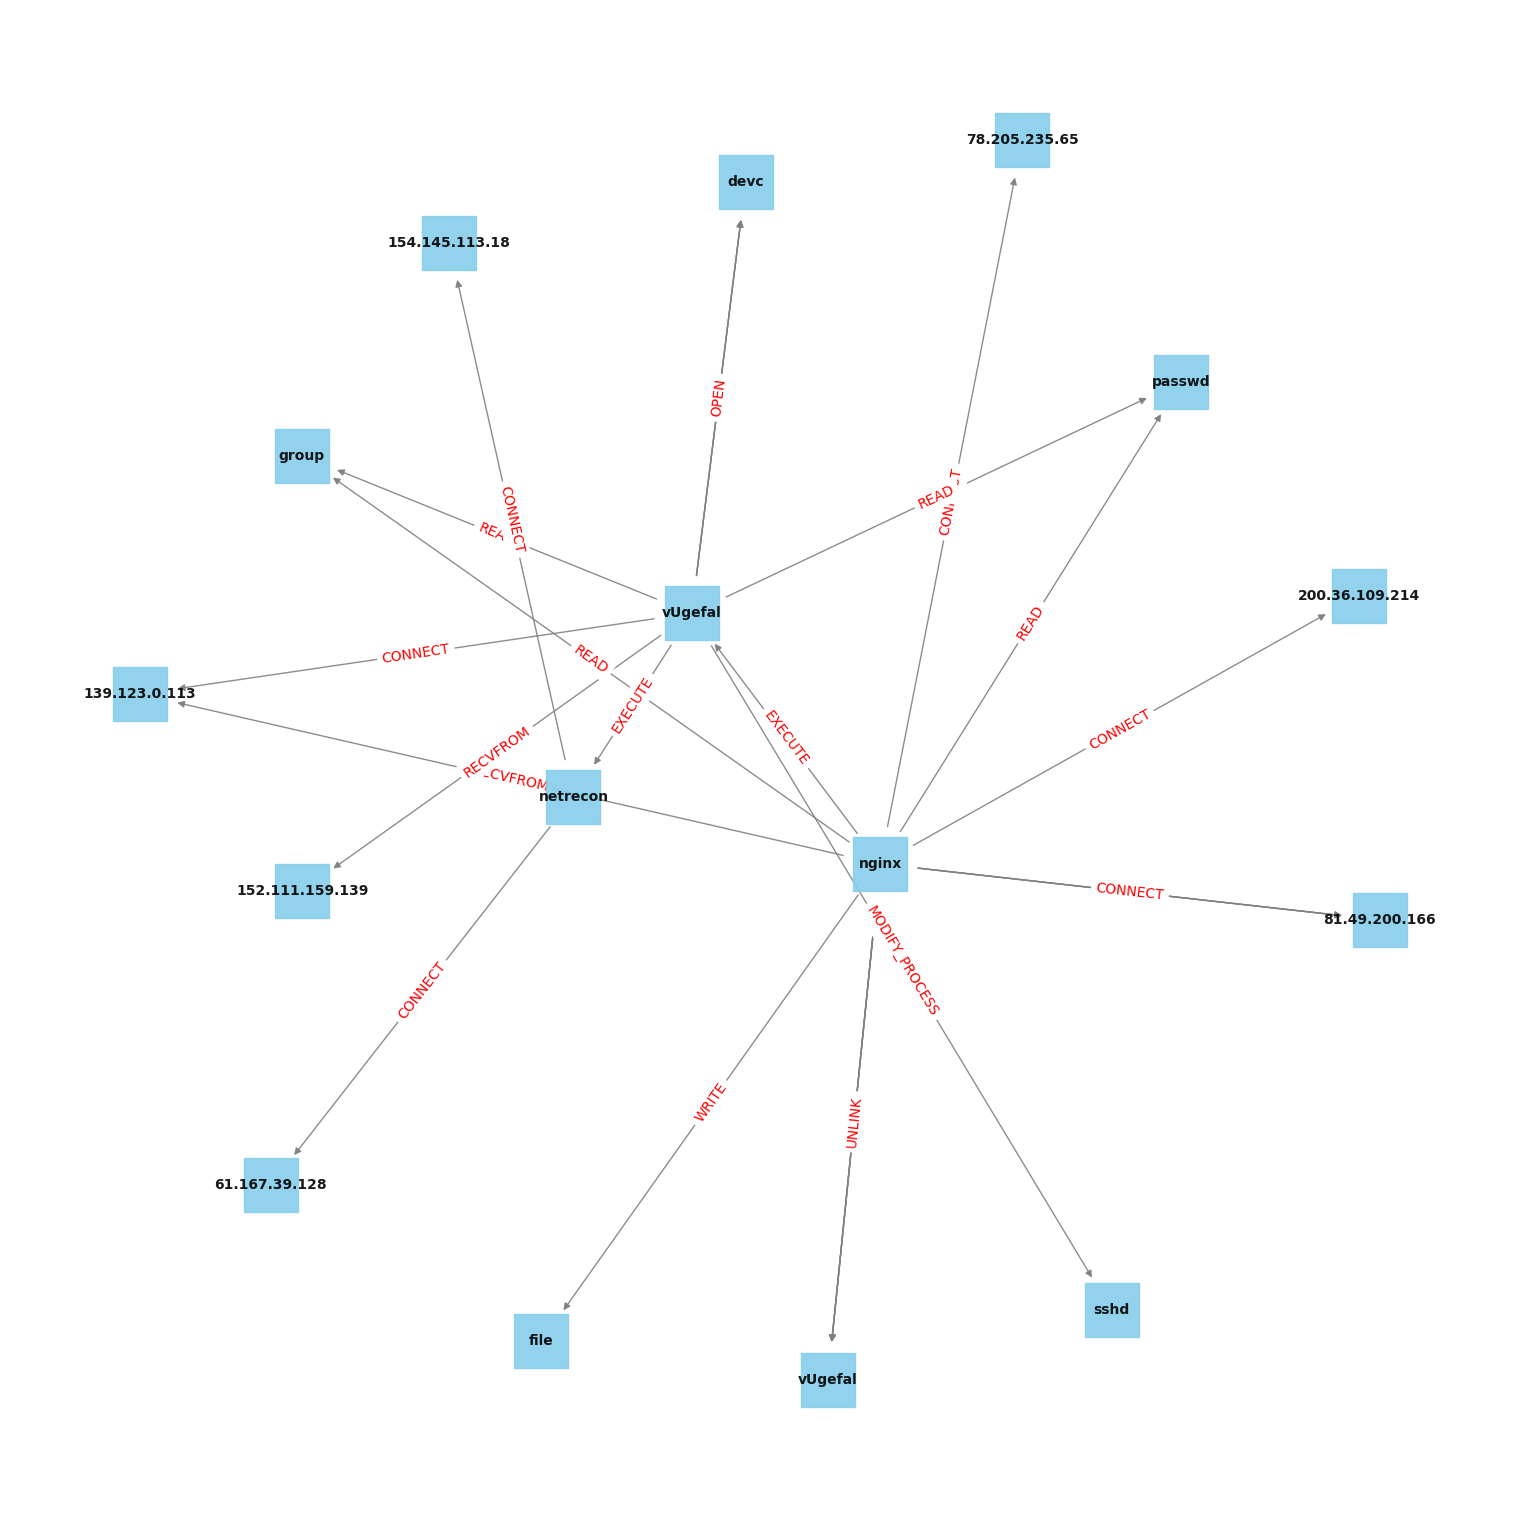

In [5]:
print("Exploring the query graphs:", query_g_name)
print("Query Graph IOCs:",query_graphs_IOCs[query_g_name]) 
explore_query_graph(query_graphs[query_g_name],query_g_name) 
draw_query_graph(query_graphs[query_g_name])

## Extract Suspicious Subgraphs  

In [13]:
!python ./src/darpa_tc3/extract_rdf_subgraphs_cadets.py --test-a-qg BSD_1 --pg-name attack_BSD_1 --parallel  --output-prx DEMO

Namespace(min_nodes=3, max_nodes=200, max_edges=1000, max_iterations=20, min_iocs=1, output_prx='DEMO', abstract_edges=False, parallel=True, query_graphs_folder='./dataset/darpa_cadets/query_graphs/', ioc_file='./dataset/darpa_cadets/query_graphs_IOCs.json', dataset='darpa_cadets', training=False, n_subgraphs=None, traverse_with_time=True, test_a_qg='BSD_1', pg_name='attack_BSD_1', database_name='tc3-cadets')
Number of used cores is  62
processing query graphs
processed 4 query graphs
Extracting suspicious subgraphs for BSD_1 in PG: attack_BSD_1

processing  attack_BSD_1 with BSD_1
Extract Subgraphs From attack_BSD_1

Total number of matched nodes: 19
{'passwd': 11, 'vUgefal': 1, '81.49.200.166': 2, '78.205.235.65': 2, '200.36.109.214': 1, '139.123.0.113': 1, '154.145.113.18': 0, '61.167.39.128': 1}
labelling Suspicious nodes in: --- 0.8775734901428223 seconds ---
Memory usage :  264.05078125 MB
Extracted a suspicious subgraph with 6 nodes, and  168 edges
Traversed in  22.8977305889129

## Use GNN Model to get Similarity Scores between attack query graphs and suspicious subgraphs

In [14]:
!python ./src/main.py --dataset DARPA_CADETS --dataset-path ./dataset/darpa_cadets/DEMO/ --gnn-operator rgcn --embedding-layers 2 --learning-rate 0.001 --dropout 0 --epochs 1000 --filters-1 128 --filters-2 92 --filters-3 64 --tensor-neurons 64 --predict --predict-file BSD_1_in_attack_BSD_1.pt --log-similarity --threshold 0.4 --load ./model/kgapt/darpa_cadets/darpa_cadets_2rgcn_Lr0.001_Dr0_128-92-64_1000.pt

+---------------------+--------------------------------------------------------+
|      Parameter      |                         Value                          |
+=====================+========================================================+
| Batch size          | 128                                                    |
+---------------------+--------------------------------------------------------+
| Bins                | 16                                                     |
+---------------------+--------------------------------------------------------+
| Bottle neck neurons | 16                                                     |
+---------------------+--------------------------------------------------------+
| Dataset             | DARPA_CADETS                                           |
+---------------------+--------------------------------------------------------+
| Dataset path        | ./dataset/darpa_cadets/DEMO/                           |
+---------------------+-----

## Generate Investigation reports for detected subgraphs

***************************************************
The model name: darpa_cadets_2rgcn_Lr0.001_Dr0_128-92-64_1000
Initial Investigation Report
Number of Detected subgraphs 2
Showing top 10 detected subgraphs


,similarity_score,number_of_nodes,number_of_edges,number_of_covered_IOCs
0,0.55,6,168,3
1,0.55,6,168,3


*************************************
The Highest Detected Subgraph alignments with the Query Graph 
*************************************
The Query Graph: BSD_1 statistics

The Query Graph: BSD_1 statistics
Number of nodes:  16
Number of edges:  25
Query Graph IOCs: {'file': ['passwd', 'vUgefal'], 'ip': ['81.49.200.166', '78.205.235.65', '200.36.109.214', '139.123.0.113', '154.145.113.18', '61.167.39.128']}

Unique nodes type: ['FILE', 'PROCESS', 'FLOW']
FILE :  5
PROCESS :  4
FLOW :  7

Unique edges type: ['EXECUTE', 'OPEN', 'MODIFY_PROCESS', 'WRITE', 'READ', 'RECVMSG', 'SENDMSG', 'MODIFY_FILE_ATTRIBUTES', 'UNLINK', 'CONNECT', 'RECVFROM']
EXECUTE :  3
OPEN :  1
MODIFY_PROCESS :  1
WRITE :  3
READ :  4
RECVMSG :  1
SENDMSG :  1
MODIFY_FILE_ATTRIBUTES :  2
UNLINK :  1
CONNECT :  6
RECVFROM :  2
**************
Highest detected subgraph
The covered attack IOCs are: {'139.123.0.113', '61.167.39.128', 'passwd'}
The Subgraph has 0.375 percent of the Query Graph IOCs
The subgraph statistics


,description,timestamp
0,a process SENDTO the flow with remote_ip: 139.123.0.113 which is an IOC,2018-04-06 11:33:16-04:00
1,a process EXECUTE the file with object_paths: vugefal which match the IOC: vUgefal,2018-04-06 11:33:16-04:00
2,a process RECVFROM the flow with remote_ip: 139.123.0.113 which is an IOC,2018-04-06 11:33:16-04:00
3,a process CONNECT the flow with remote_ip: 139.123.0.113 which is an IOC,2018-04-06 11:33:16-04:00
4,a process FORK a process,2018-04-06 11:33:16-04:00
5,a process READ the file with object_paths: passwd which is an IOC,2018-04-06 11:33:56-04:00
6,a process SENDTO the flow with remote_ip: 139.123.0.113 which is an IOC,2018-04-06 11:33:56-04:00
7,a process LSEEK the file with object_paths: passwd which is an IOC,2018-04-06 11:33:56-04:00
8,a process RECVFROM the flow with remote_ip: 139.123.0.113 which is an IOC,2018-04-06 11:33:56-04:00
9,a process CLOSE the file with object_paths: passwd which is an IOC,2018-04-06 11:33:56-04:00


************************
Report IOCs timestamps of detected subgraph
The IOC 139.123.0.113  appear in provenance graph attack_BSD_1
It perform 74 actions, as following:


,action,timestamp
0,recvfrom,2018-04-06 11:33:16-04:00
1,recvfrom,2018-04-06 11:33:56-04:00
2,recvfrom,2018-04-06 11:33:56-04:00
3,recvfrom,2018-04-06 11:38:21-04:00
4,recvfrom,2018-04-06 11:38:21-04:00


The IOC passwd  appear in provenance graph attack_BSD_1
It perform 88 actions, as following:


,action,timestamp
0,lseek,2018-04-06 11:33:56-04:00
1,lseek,2018-04-06 11:47:34-04:00
2,lseek,2018-04-06 12:04:57-04:00
3,lseek,2018-04-06 12:04:57-04:00
4,lseek,2018-04-06 12:04:57-04:00


The IOC vUgefal  appear in provenance graph attack_BSD_1
It perform 1 actions, as following:


,action,timestamp
0,execute,2018-04-06 11:33:16-04:00


The IOC 61.167.39.128  appear in provenance graph attack_BSD_1
It perform 3 actions, as following:


,action,timestamp
0,close,2018-04-06 11:43:04-04:00
1,sendto,2018-04-06 11:43:04-04:00
2,connect,2018-04-06 11:43:04-04:00


***************************************************
Drawing all detected cases


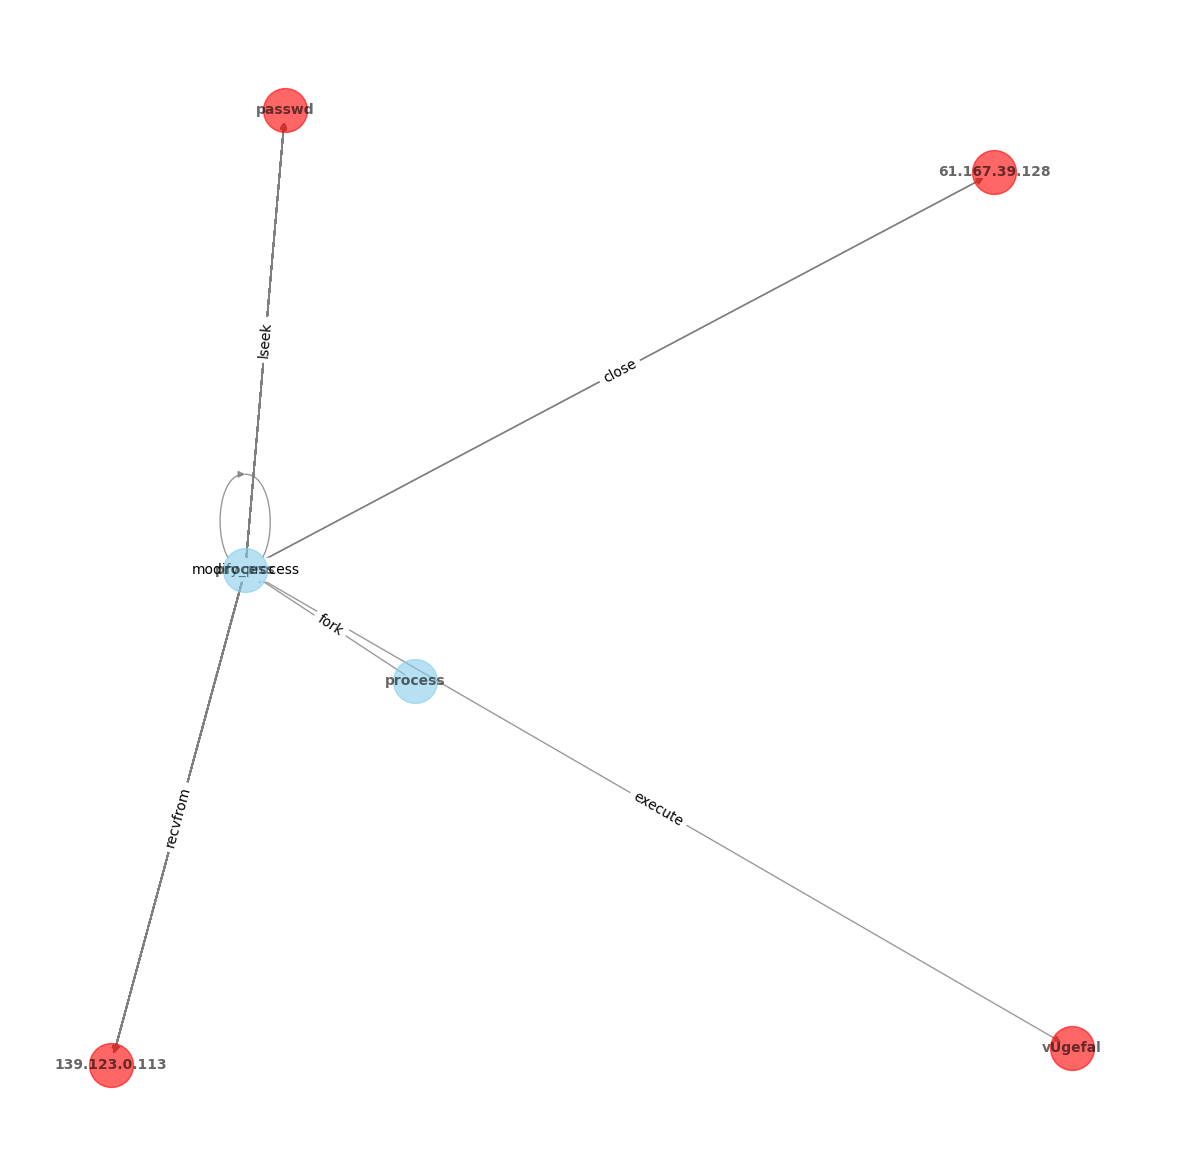

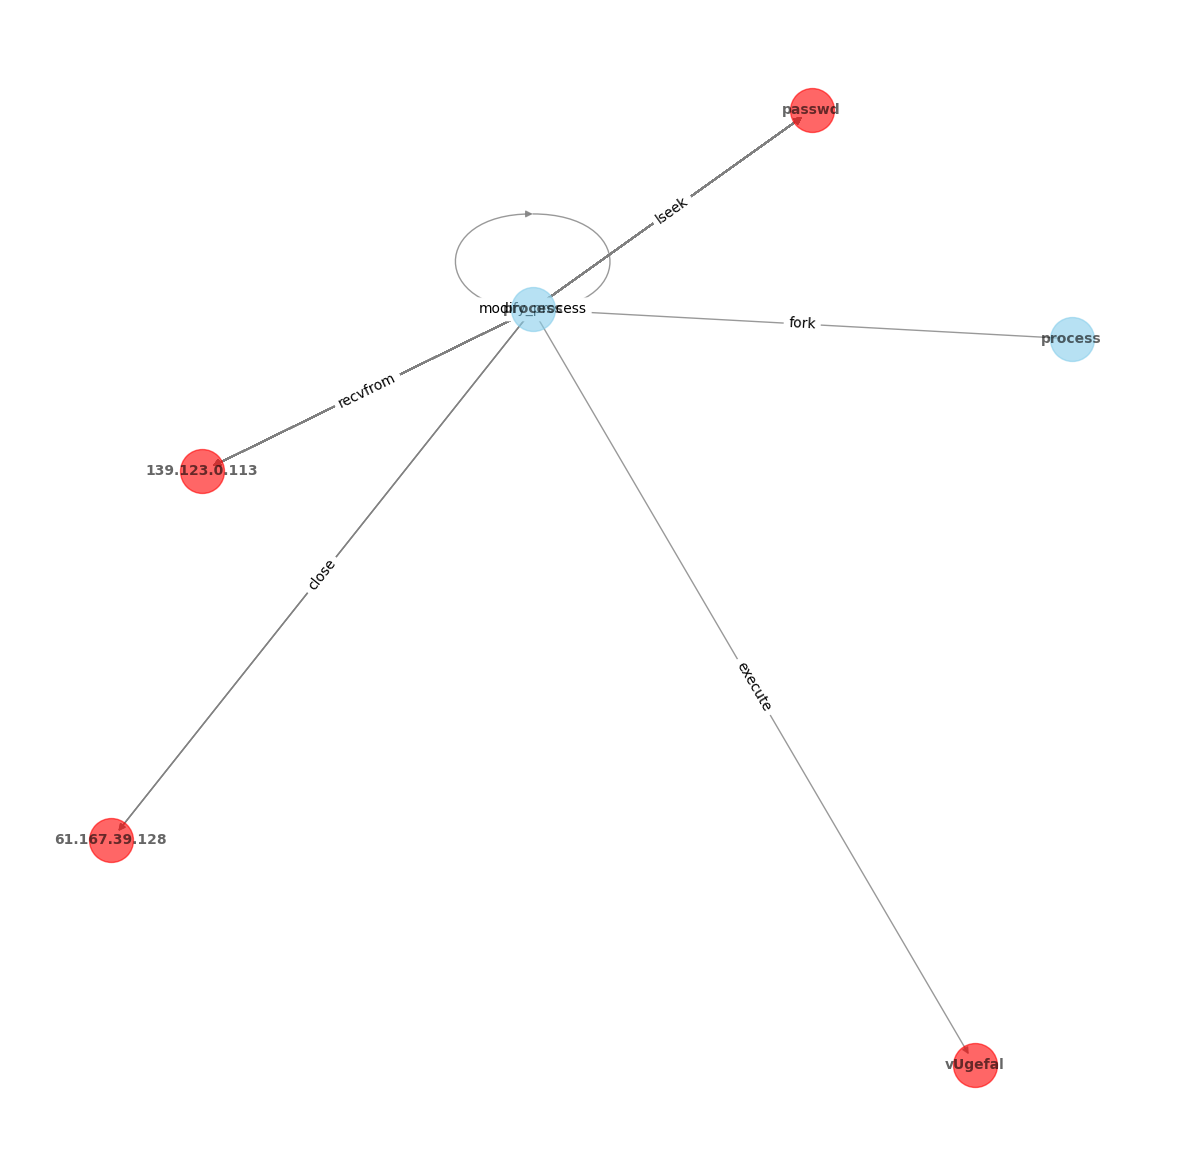

In [12]:
tested_subgraphs_nx, attack_description_df = inspect_cases(exp_path,provenance_g_name,query_g_name,model_name)

___________________________


# DEMO BSD_2

In [13]:
query_g_name = "BSD_2"
provenance_g_name = "attack_BSD_2"
exp_path = "./dataset/darpa_cadets/DEMO/predict/"
model_name = "darpa_cadets_2rgcn_Lr0.001_Dr0_128-92-64_1000"

Exploring the query graphs: BSD_2
Query Graph IOCs: {'file': ['passwd'], 'ip': ['25.159.96.207', '155.162.39.48', '76.56.184.25']}

The Query Graph: BSD_2 statistics
Number of nodes:  10
Number of edges:  13
Query Graph IOCs: {'file': ['passwd'], 'ip': ['25.159.96.207', '155.162.39.48', '76.56.184.25']}

Unique nodes type: ['FLOW', 'FILE', 'PROCESS']
FLOW :  4
FILE :  3
PROCESS :  3

Unique edges type: ['MODIFY_PROCESS', 'WRITE', 'CONNECT', 'MODIFY_FILE_ATTRIBUTES', 'SENDMSG', 'RECVMSG', 'RECVFROM', 'READ']
MODIFY_PROCESS :  2
WRITE :  1
CONNECT :  3
MODIFY_FILE_ATTRIBUTES :  1
SENDMSG :  1
RECVMSG :  1
RECVFROM :  2
READ :  2


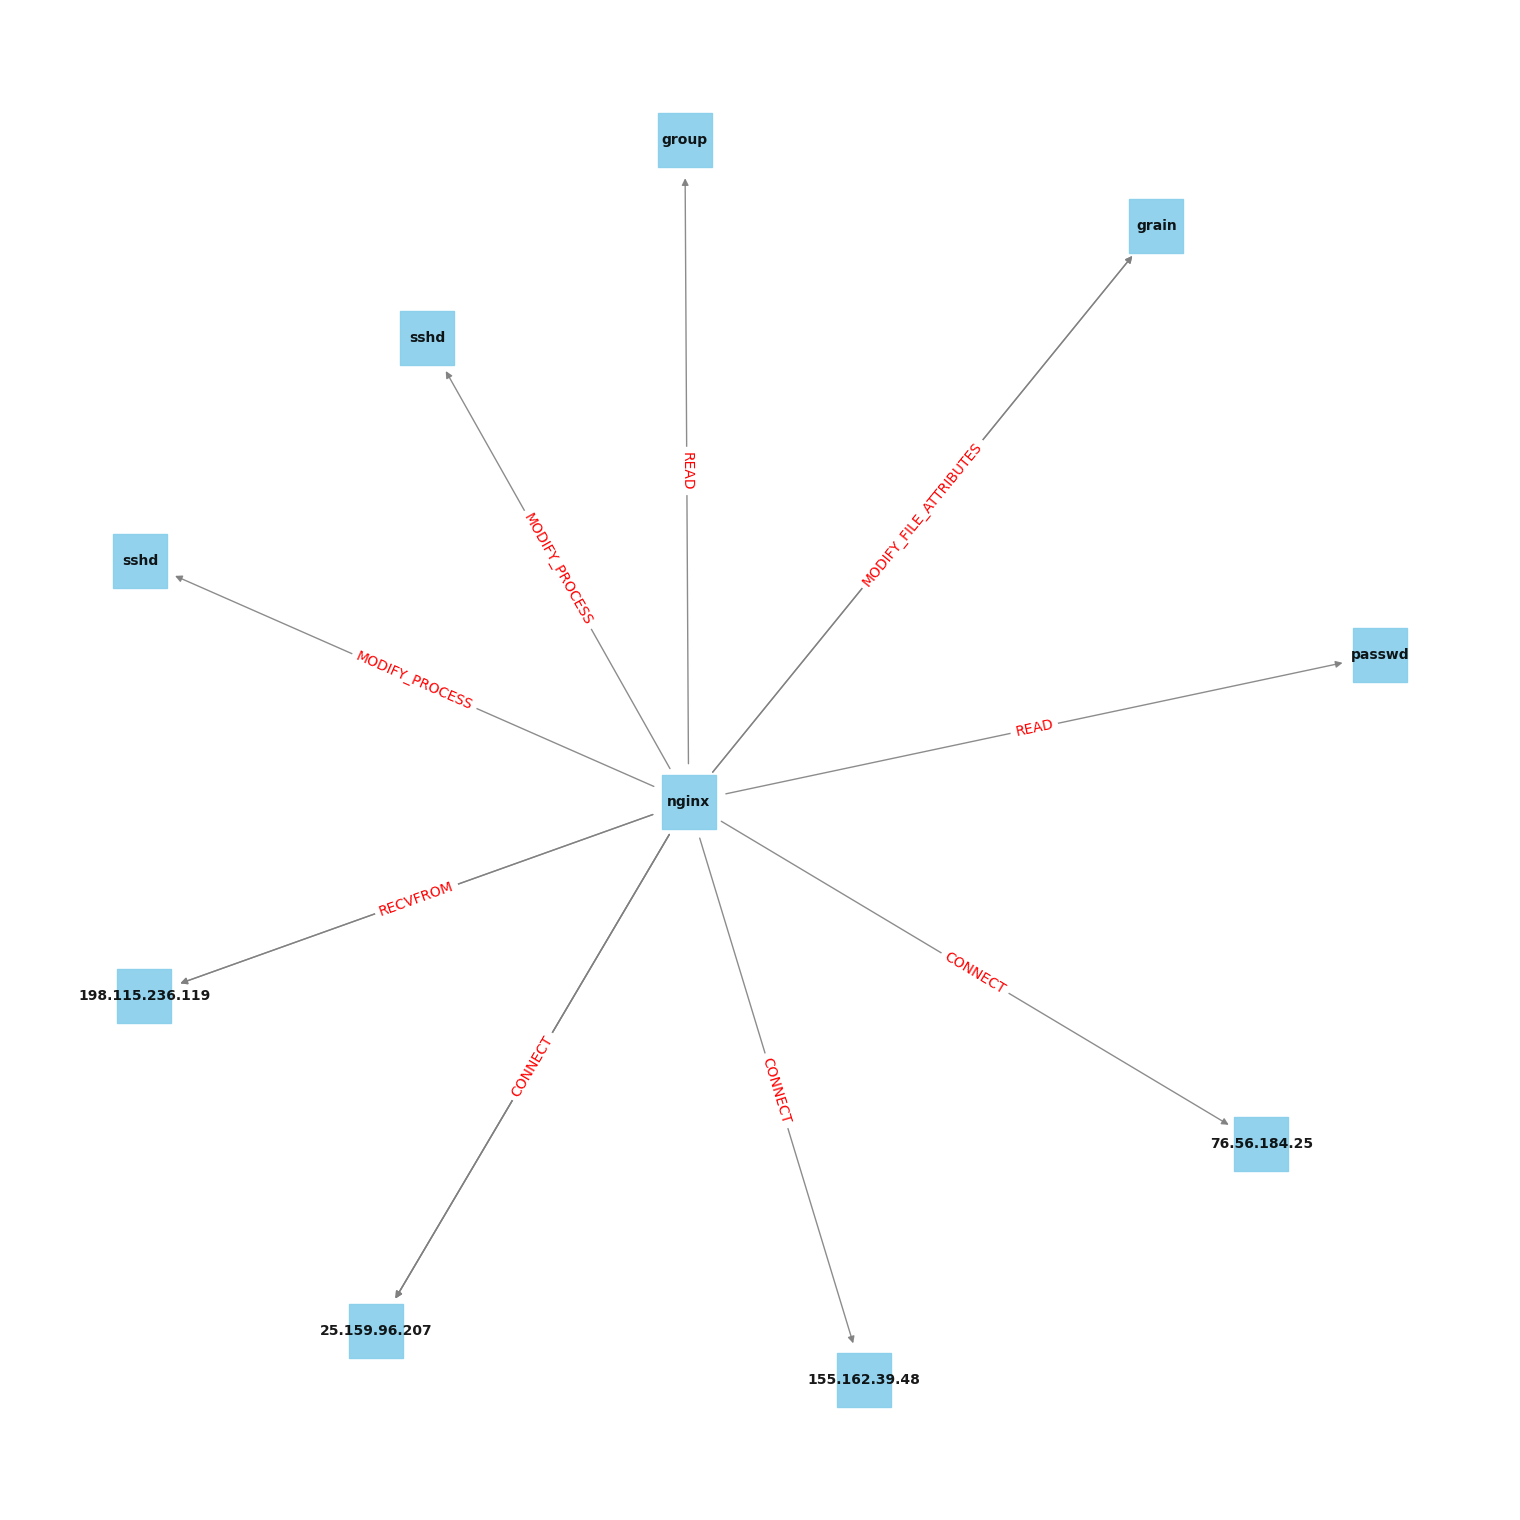

In [23]:
print("Exploring the query graphs:", query_g_name)
print("Query Graph IOCs:",query_graphs_IOCs[query_g_name]) 
explore_query_graph(query_graphs[query_g_name],query_g_name) 
draw_query_graph(query_graphs[query_g_name])

In [24]:
!python ./src/darpa_tc3/extract_rdf_subgraphs_cadets.py --test-a-qg BSD_2 --pg-name attack_BSD_2 --parallel  --output-prx DEMO

Namespace(min_nodes=3, max_nodes=200, max_edges=1000, max_iterations=20, min_iocs=1, output_prx='DEMO', abstract_edges=False, parallel=True, query_graphs_folder='./dataset/darpa_cadets/query_graphs/', ioc_file='./dataset/darpa_cadets/query_graphs_IOCs.json', dataset='darpa_cadets', training=False, n_subgraphs=None, traverse_with_time=True, test_a_qg='BSD_2', pg_name='attack_BSD_2', database_name='tc3-cadets')
Number of used cores is  62
processing query graphs
processed 4 query graphs
Extracting suspicious subgraphs for BSD_2 in PG: attack_BSD_2

processing  attack_BSD_2 with BSD_2
Extract Subgraphs From attack_BSD_2

Total number of matched nodes: 14
{'passwd': 11, '25.159.96.207': 1, '155.162.39.48': 1, '76.56.184.25': 1}
labelling Suspicious nodes in: --- 0.755108118057251 seconds ---
Memory usage :  266.3515625 MB
Extracted a suspicious subgraph with 6 nodes, and  223 edges
Traversed in  11.963313817977905 seconds
Extracted a suspicious subgraph with 6 nodes, and  223 edges
Travers

In [25]:
!python ./src/main.py --dataset DARPA_CADETS --dataset-path ./dataset/darpa_cadets/DEMO/ --gnn-operator rgcn --embedding-layers 2 --learning-rate 0.001 --dropout 0 --epochs 1000 --filters-1 128 --filters-2 92 --filters-3 64 --tensor-neurons 64 --predict --predict-file BSD_2_in_attack_BSD_2.pt --log-similarity --threshold 0.4 --load ./model/kgapt/darpa_cadets/darpa_cadets_2rgcn_Lr0.001_Dr0_128-92-64_1000.pt

+---------------------+--------------------------------------------------------+
|      Parameter      |                         Value                          |
+=====================+========================================================+
| Batch size          | 128                                                    |
+---------------------+--------------------------------------------------------+
| Bins                | 16                                                     |
+---------------------+--------------------------------------------------------+
| Bottle neck neurons | 16                                                     |
+---------------------+--------------------------------------------------------+
| Dataset             | DARPA_CADETS                                           |
+---------------------+--------------------------------------------------------+
| Dataset path        | ./dataset/darpa_cadets/DEMO/                           |
+---------------------+-----

***************************************************
The model name: darpa_cadets_2rgcn_Lr0.001_Dr0_128-92-64_1000
Initial Investigation Report
Number of Detected subgraphs 4
Showing top 10 detected subgraphs


,similarity_score,number_of_nodes,number_of_edges,number_of_covered_IOCs
0,0.42,6,223,4
1,0.42,6,223,4
2,0.42,6,223,4
3,0.42,6,223,4


*************************************
The Highest Detected Subgraph alignments with the Query Graph 
*************************************
The Query Graph: BSD_2 statistics

The Query Graph: BSD_2 statistics
Number of nodes:  10
Number of edges:  13
Query Graph IOCs: {'file': ['passwd'], 'ip': ['25.159.96.207', '155.162.39.48', '76.56.184.25']}

Unique nodes type: ['FILE', 'PROCESS', 'FLOW']
FILE :  3
PROCESS :  3
FLOW :  4

Unique edges type: ['MODIFY_PROCESS', 'WRITE', 'READ', 'RECVMSG', 'SENDMSG', 'MODIFY_FILE_ATTRIBUTES', 'CONNECT', 'RECVFROM']
MODIFY_PROCESS :  2
WRITE :  1
READ :  2
RECVMSG :  1
SENDMSG :  1
MODIFY_FILE_ATTRIBUTES :  1
CONNECT :  3
RECVFROM :  2
**************
Highest detected subgraph
The covered attack IOCs are: {'155.162.39.48', 'passwd', '76.56.184.25', '25.159.96.207'}
The Subgraph has 1.0 percent of the Query Graph IOCs
The subgraph statistics
************************************
The Textual description of the highest detected subgraphs


,description,timestamp
0,a process SENDTO the flow with remote_ip: 155.162.39.48 which is an IOC,2018-04-11 15:08:32-04:00
1,a process RECVFROM the flow with remote_ip: 25.159.96.207 which is an IOC,2018-04-11 15:08:32-04:00
2,a process WRITE the flow with remote_ip: 25.159.96.207 which is an IOC,2018-04-11 15:08:32-04:00
3,a process SENDTO the flow with remote_ip: 76.56.184.25 which is an IOC,2018-04-11 15:08:32-04:00
4,a process CONNECT the flow with remote_ip: 76.56.184.25 which is an IOC,2018-04-11 15:08:32-04:00
5,a process RECVFROM the flow with remote_ip: 76.56.184.25 which is an IOC,2018-04-11 15:08:32-04:00
6,a process ACCEPT the flow with remote_ip: 25.159.96.207 which is an IOC,2018-04-11 15:08:32-04:00
7,a process RECVFROM the flow with remote_ip: 155.162.39.48 which is an IOC,2018-04-11 15:08:32-04:00
8,a process CONNECT the flow with remote_ip: 155.162.39.48 which is an IOC,2018-04-11 15:08:32-04:00
9,a process CLOSE the flow with remote_ip: 25.159.96.207 which is an IOC,2018-04-11 15:08:32-04:00


************************
Report IOCs timestamps of detected subgraph
The IOC 155.162.39.48  appear in provenance graph attack_BSD_2
It perform 101 actions, as following:


,action,timestamp
0,recvfrom,2018-04-11 15:08:32-04:00
1,recvfrom,2018-04-11 15:08:44-04:00
2,recvfrom,2018-04-11 15:08:44-04:00
3,recvfrom,2018-04-11 15:08:47-04:00
4,recvfrom,2018-04-11 15:08:50-04:00


The IOC passwd  appear in provenance graph attack_BSD_2
It perform 106 actions, as following:


,action,timestamp
0,close,2018-04-11 15:08:44-04:00
1,close,2018-04-11 15:08:53-04:00
2,close,2018-04-11 15:13:12-04:00
3,close,2018-04-11 15:08:53-04:00
4,close,2018-04-11 15:08:53-04:00


The IOC 76.56.184.25  appear in provenance graph attack_BSD_2
It perform 8 actions, as following:


,action,timestamp
0,sendto,2018-04-11 15:08:32-04:00
1,connect,2018-04-11 15:08:32-04:00
2,recvfrom,2018-04-11 15:08:32-04:00
3,recvfrom,2018-04-11 15:08:32-04:00
4,recvfrom,2018-04-11 15:08:32-04:00


The IOC 25.159.96.207  appear in provenance graph attack_BSD_2
It perform 4 actions, as following:


,action,timestamp
0,accept,2018-04-11 15:08:32-04:00
1,recvfrom,2018-04-11 15:08:32-04:00
2,close,2018-04-11 15:08:32-04:00
3,write,2018-04-11 15:08:32-04:00


***************************************************
Drawing all detected cases


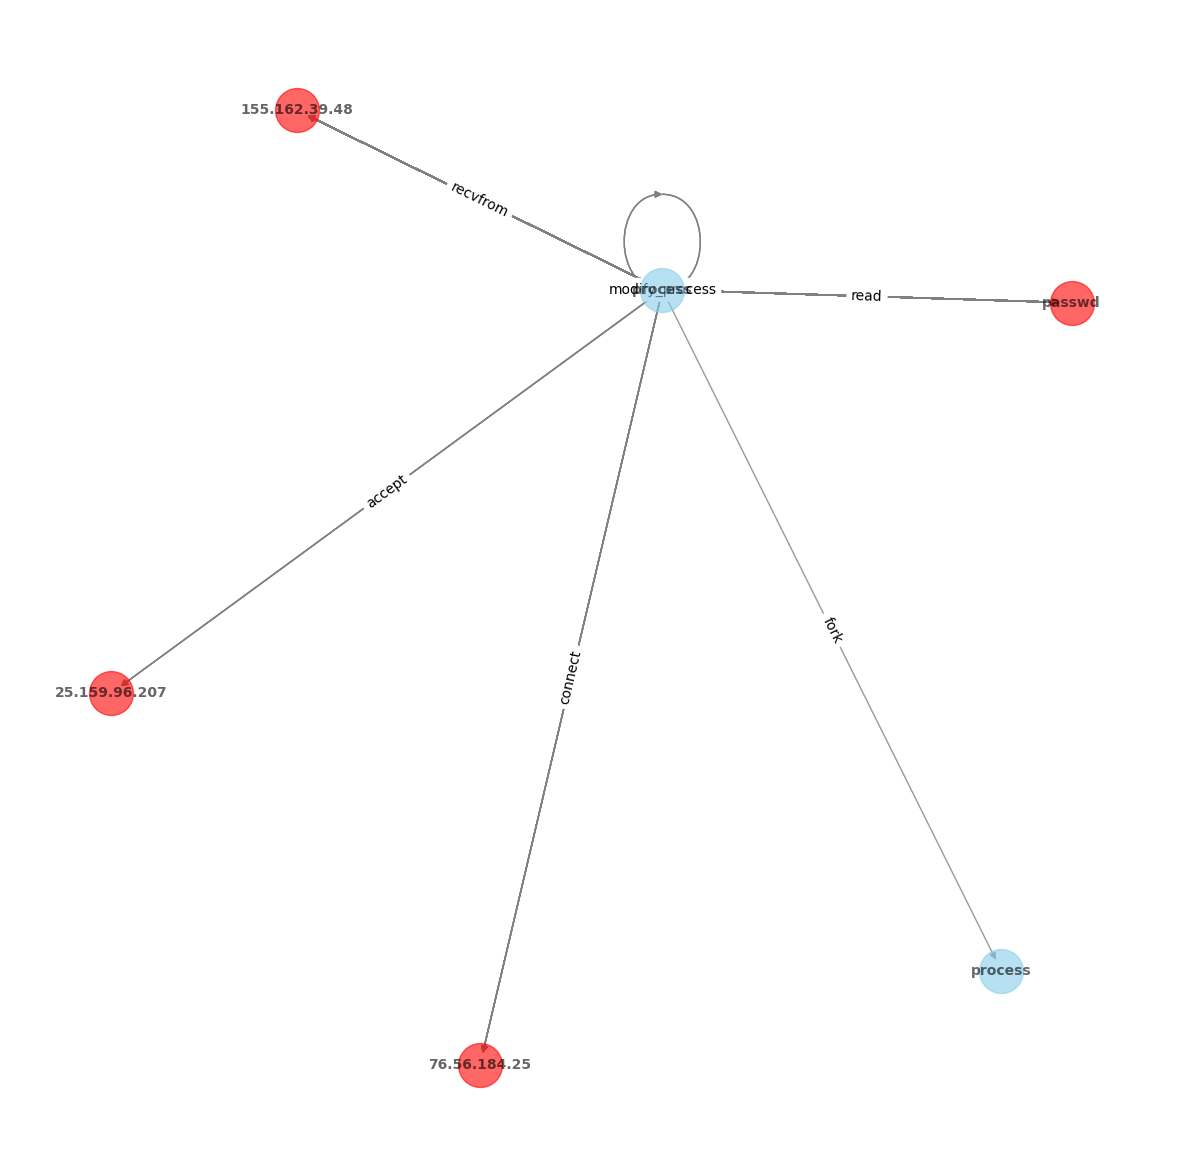

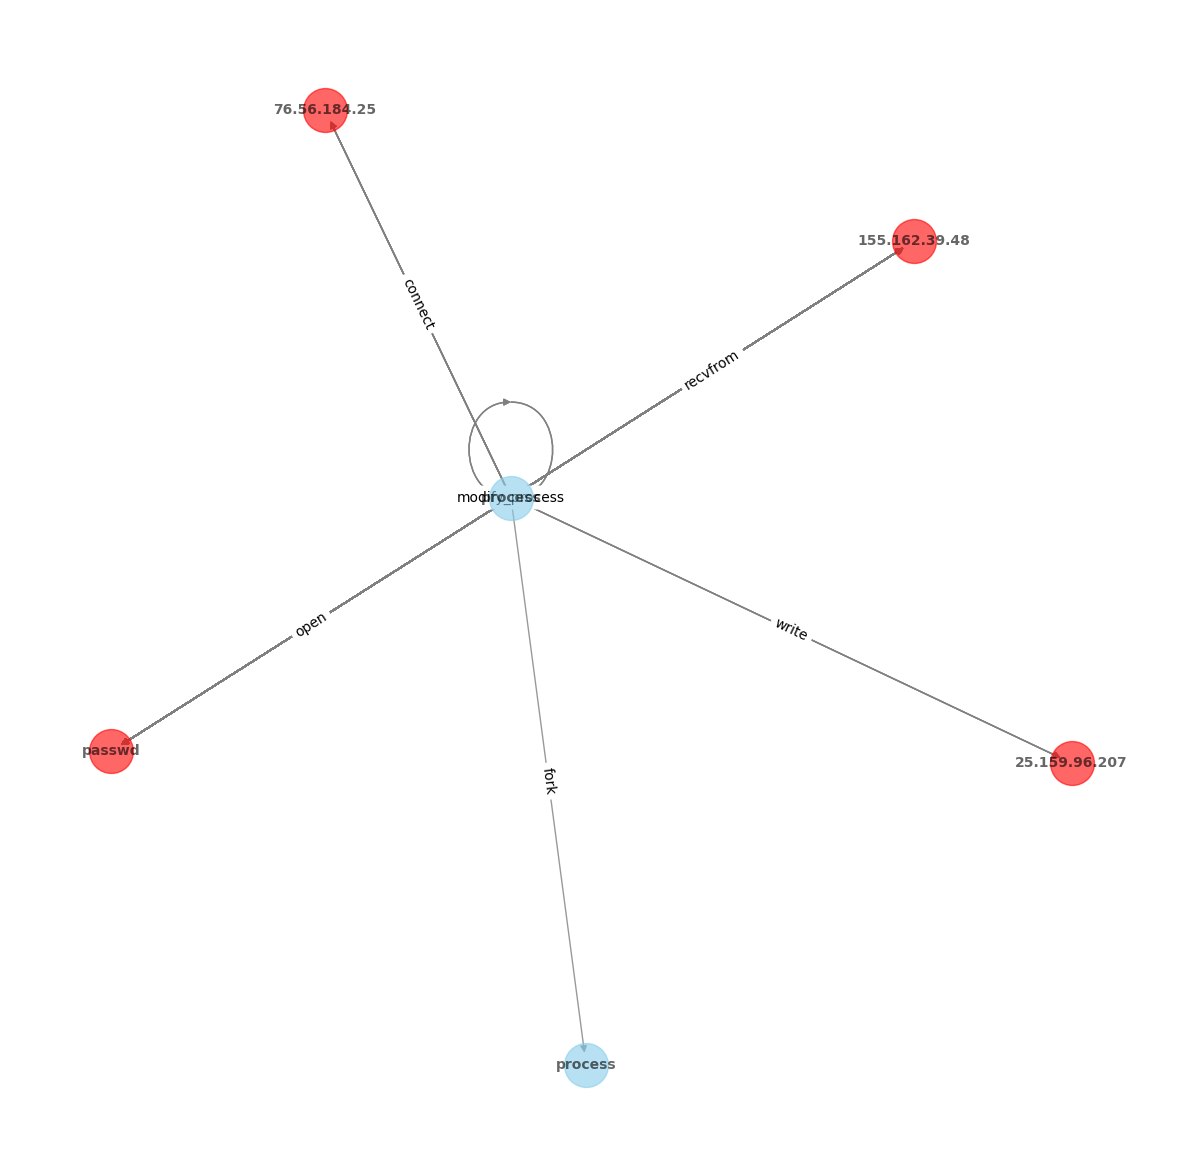

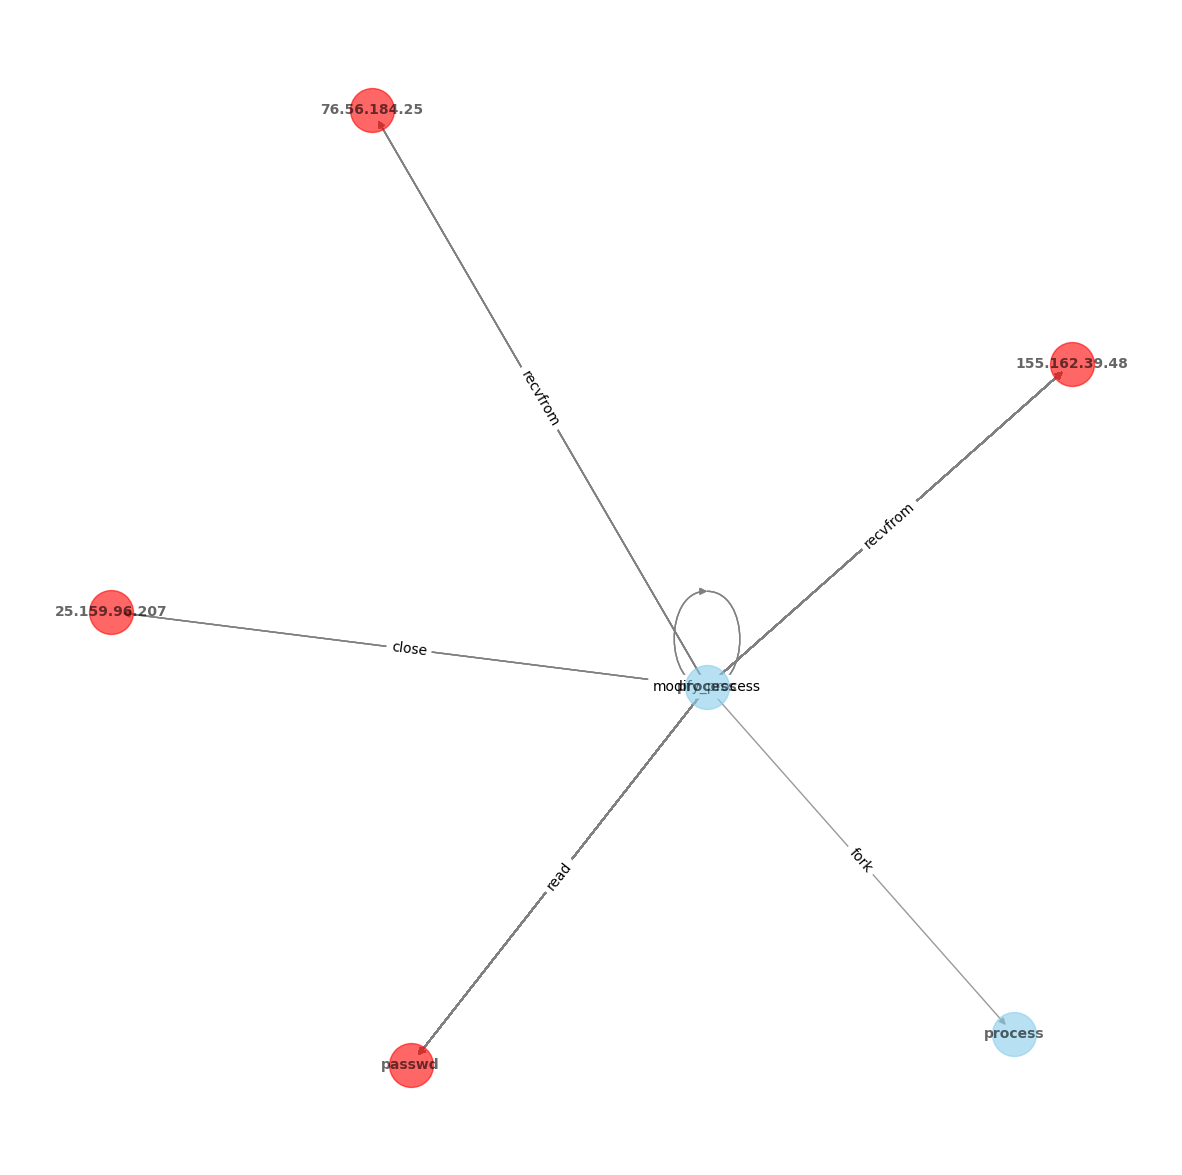

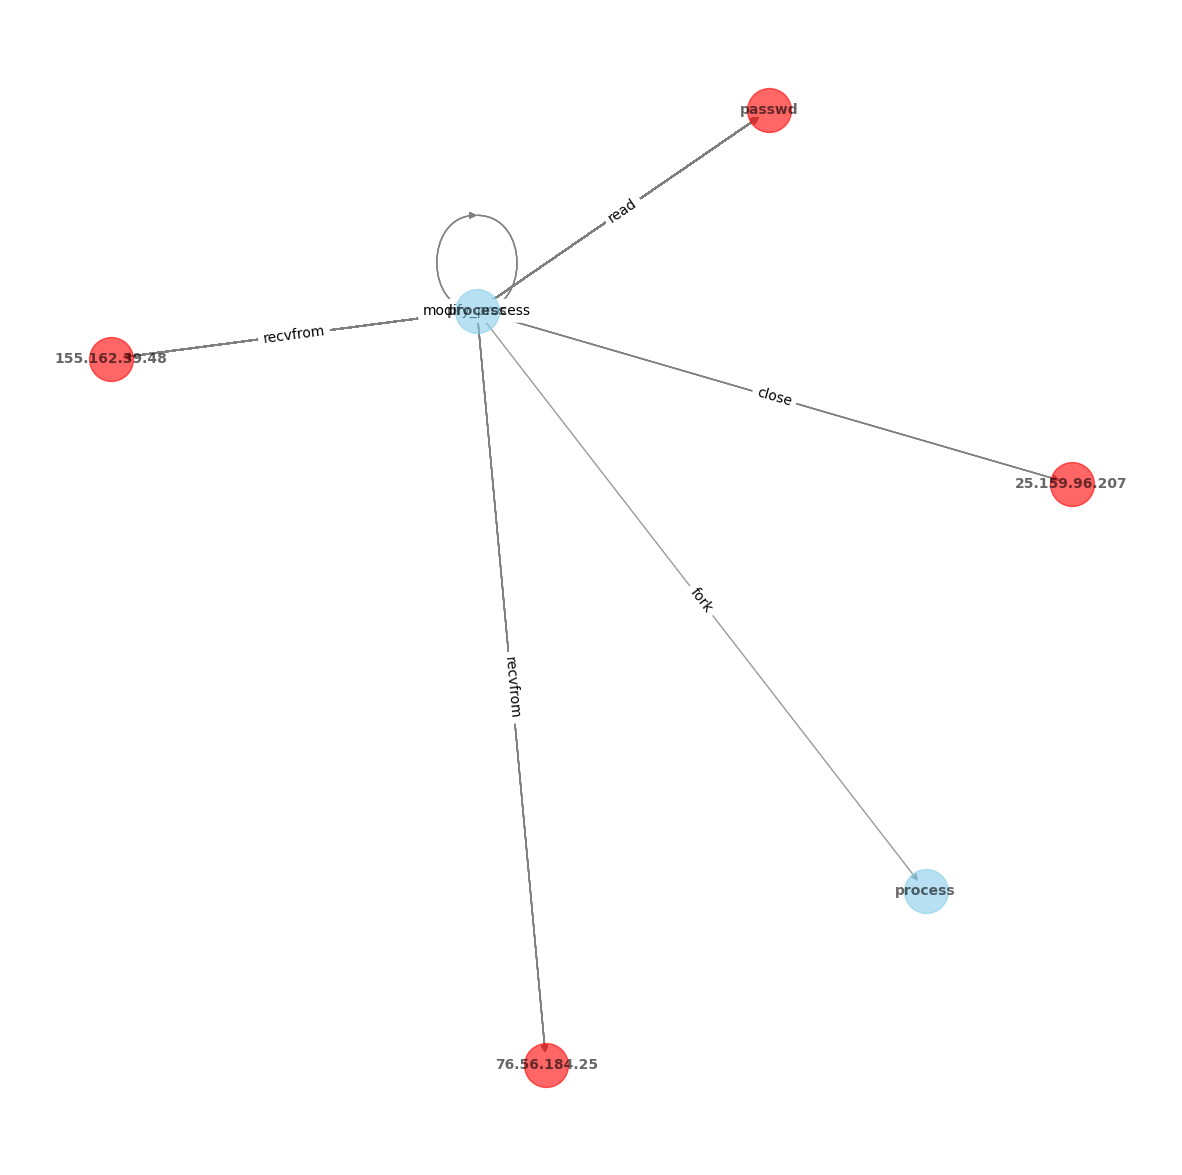

In [15]:
tested_subgraphs_nx, attack_description_df = inspect_cases(exp_path,provenance_g_name,query_g_name,model_name)